<a href="https://colab.research.google.com/github/LaurianeRamuzat/ML_course/blob/main/src/Project_horoscope.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MATHEMATICS OF DEEP LEARNING ALGORITHMS 2 - Final Project**



# ***TEXT GENERATION: Algorithm for sign-specific horoscopes generation***





The aim of this project is to predict horoscopes for a chosen astrological sign. It was conducted for the Machine Learning course. For computational power reasons, the code was executed with the help of Google colab. The authors are: Lauriane Ramuzat and Camille Girou.

## **PART 0 : Packages and libraries import**

In [ ]:
## Basic computational libraries 
import pandas as pd
import numpy as np
import math
from operator import itemgetter

## Graphical libraries
import matplotlib.pyplot as plt

## NLP libraries
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from sklearn.feature_extraction.text import TfidfVectorizer
#%pip install wordcloud
from wordcloud import WordCloud

## Tensorflow libraries
!pip install tensorflow==2.0.0
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, LSTM, Embedding, Dense, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.utils as ku 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## **PART 1: Data Preprocessing**

### **Step 1: Dataset import**


The dataset used is composed of the **daily horoscopes from 2013 to 2016** published on the NY Post website. 

The dataset is under CSV format and records **4 different variables**: 


*   a variable which associates a unique index number to each observation, that we rename **id**;

*   a variable which stores the full text horoscope for this observation, called **horoscope**;

*   a date variable corresponding to the publication date of each observation, named **date**

*   a variable indicating the sign to which the daily horoscope is associated, renamed **sign**.

***Creation of a dictionary to properly load and handle character string data***

In [ ]:
class StringConverter(dict):
    def __contains__(self, item):
        return True

    def __getitem__(self, item):
        return str

    def get(self, default=None):
        return str

***Data file download (charge in Google Colab)***






In [ ]:
from google.colab import files
files.upload()

Saving horoscopes.csv to horoscopes.csv


{'horoscopes.csv': b'0|You\xe2\x80\x99re not the sort to play safe and even if you have been a bit more cautious than usual in recent weeks you will more than make up for it over the next few days. Plan your new adventure today and start working on it tomorrow.|12-01-2013|aries\n1|There is no such thing as something for nothing and if you do not quite believe that now you will believe it by the end of the day. If you lose something valuable accept it as the price you must pay to learn this important lesson.|12-02-2013|aries\n2|As the new moon falls in one of the more adventurous areas of your chart you will take the kind of risk you might usually steer clear of. No doubt it will surprise a few people, including yourself, when it pays off handsomely.|12-03-2013|aries\n3|You will hear something amazing today but can you believe it? If it sounds too good to be true then it might be wise to check it out. Commit too soon and you could find you have signed up for something that does you no g

***Read the dataset***




Remark: The separator is not the classical CSV separator, i.e. the comma, but the vertical line |.




In [ ]:
#Load data ussing the dictionary StringConverter()
df= pd.read_csv('horoscopes.csv', sep="|", header = None, converters=StringConverter())
#Rename dataset columns (according to the specifications introduced previously)
df = df.rename(columns = {0 : 'id' , 1: 'horoscope' , 2 : 'date' , 3 : 'sign'})

In [ ]:
df.shape
print("The Horoscope dataset set contains",df.shape[0], "observations, i.e. daily horoscopes examples.")
print("Each horoscope example is described by",df.shape[1], "variables, as introduced previously.")

The Horoscope dataset set contains 12962 observations, i.e. daily horoscopes examples.
Each horoscope example is described by 4 variables, as introduced previously.


**Visualize the 10 first lines of the dataset**

In [ ]:
pd.options.display.max_colwidth = 150
df.head(10)

id  ...   sign
0  0  ...  aries
1  1  ...  aries
2  2  ...  aries
3  3  ...  aries
4  4  ...  aries
5  5  ...  aries
6  6  ...  aries
7  7  ...  aries
8  8  ...  aries
9  9  ...  aries

[10 rows x 4 columns]

**Display one horoscope prediction example**

In [ ]:
print("The following horoscope example concern", df.iloc[0,3],"and was published on the", df.iloc[0,2], ":")
print(type(df.iloc[0,1]),df.iloc[0,1])

The following horoscope example concern aries and was published on the 12-01-2013 :
<class 'str'> You’re not the sort to play safe and even if you have been a bit more cautious than usual in recent weeks you will more than make up for it over the next few days. Plan your new adventure today and start working on it tomorrow.


**Number/Proportion of horoscope relative to each sign**

In [ ]:
#Extract count and proportion for each sign
nb_sign = df['sign'].value_counts()
prop_sign = df['sign'].value_counts(normalize=True)
#Merge the two previous results
relative_sign = pd.concat([nb_sign, prop_sign], axis=1)
#Rename the final columns 
relative_sign.columns = ['nb','prop']

print(relative_sign)

               nb      prop
leo          1085  0.083706
scorpio      1084  0.083629
gemini       1083  0.083552
libra        1082  0.083475
pisces       1081  0.083398
taurus       1080  0.083320
sagittarius  1080  0.083320
capricorn    1079  0.083243
virgo        1079  0.083243
aquarius     1078  0.083166
aries        1077  0.083089
cancer       1074  0.082858


Hence, each sign is represented by on average 1080 horoscope examples. 
The small differences between signs suggest that some sign's horoscopes were not scrapped from the NY post website on several dates. 

This is not an issue, since we have enough examples for each sign to perform analysis. 

###**Step 2: Cleaning step for NLP methods**

**First cleaning procedure of the data**

Define functions for each step of the cleaning

In [ ]:
#Convert text to lowercase
def convert_text_to_lowercase(df, colname):
    df[colname] = df[colname].str.lower()
    return df
  
def not_regex(pattern):
        return r"((?!{}).)".format(pattern)

#remove punctuation and new line characters '\n'
def remove_punctuation(df, colname):
    df[colname] = df[colname].str.replace('\n', ' ')
    df[colname] = df[colname].str.replace('\r', ' ')
    alphanumeric_characters_extended = '(\\b[-/]\\b|[a-zA-Z0-9])'
    df[colname] = df[colname].str.replace(not_regex(alphanumeric_characters_extended), ' ')
    return df

#Tokenize sentences
def tokenize_sentence(df, colname):
    df[colname] = df[colname].str.split()
    return df

#Remove all stopwords
def remove_stop_words(df, colname):
    stop_words = stopwords.words('english')
    df[colname] = df[colname].apply(lambda x: [word for word in x if word not in stop_words])
    return df

#Remove stopwords specific to the horoscope case
def spec_stop_words(df, colname):
    undesired_words = ['today', 'weekend', 'weekends', 'day', 'days', 'week', 'weeks', 'time', 'month', 'months', 'tomorrow', 'hours','year', 'years',
                       'something', 'thing', 'things' , 'next', 'anything', 'make', 'may', 'need', 'way', 'take', 'get', 'must',
                       'know', 'go', 'people', 'one', 'someone']
    df[colname] = df[colname].apply(lambda x: [word for word in x if word not in undesired_words])
    return df

#convert tokenized text to text
def reverse_tokenize_sentence(df, colname):
    df[colname] = df[colname].map(lambda word: ' '.join(word))
    return df

#First cleaning: do not remove the stopwords specific to horoscope.
#Keeping those stopword is necessary for text generation: we want to produce horoscope with the same structure and formulation as original examples.
#When perforiming a TF-IDF analysis, they will not obtain high scores since they are very frequent among the corpus. 

def text_cleaning(df, colname):
  
    df_clean1 = (
        df
        .pipe(convert_text_to_lowercase, colname)
        .pipe(remove_punctuation, colname)
        .pipe(tokenize_sentence, colname)
        .pipe(remove_stop_words, colname)
        .pipe(reverse_tokenize_sentence, colname)
    )
    return df_clean1

#Second cleaning: remove the stopwords specific to horoscope to be able to perform "most frequent word" analysis and obtain sign-specific results.
#Otherwise the horoscope specific stopwords will be part of the most frequent words for all sign.
def text_cleaning2(df, colname):

    df_clean2 = (
        df
        .pipe(convert_text_to_lowercase, colname)
        .pipe(remove_punctuation, colname)
        .pipe(tokenize_sentence, colname)
        .pipe(remove_stop_words, colname)
        .pipe(spec_stop_words, colname)
        .pipe(reverse_tokenize_sentence, colname)
    )
    return df_clean2

#Third cleaning: keep the stopwords to obtain meaningfull sentences.
#This cleaning procedure will be used for the text generation algorithm in the second part. 
def text_cleaning3(df, colname):
    df_clean3 = (
        df
        .pipe(convert_text_to_lowercase, colname)
        .pipe(remove_punctuation, colname)
    )
    return df_clean3

###**Step 3: By sign words analysis and wordcloud representation**

The goal is to display under a illustrative form the most relevant words for each sign, in order to highlight whether the horoscopes are sign-specific. 

We aim at generating horoscope according to the choosen sign, which makes sense if each sign is characterized prediction consistence with its supposed personnality traits. 

We will propose two analysis ways: 

*   **"Most frequent words" analysis** which basically consist in highlighting the most used words for each sign mamong all the available horoscope prediction examples.
This method requires to use the version of cleaned predictions which does not include the horoscope specific stopword.

*   **TF-IDF analysis** which highlights the most used representative words for a sign, by taking into account both the frequency of each word in the sign corpus and the specificity of these words to this sign corpus comparing to other signs ones. 
Hence for this method we used the horoscope predictions set without removing the horoscope specific stopwords because they should not be consider as important words since they appears in all sign corpus.

**Function to generate workcloud**

This function creates the wordcloud representation by selecting the 20 more frequents words.

In [ ]:
def show_wordcloud(data, title):
    wordcloud = WordCloud(
        background_color='white',
        max_words=20,
        max_font_size=40, 
        scale=3,
        stopwords = 'english',
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(6, 6))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20, color="grey")
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show() 

To perform the two analysis strategies, one neef first to concatenate all horoscope prediction examples by sign, to create one unique text for each ones. 

**Construction of one unique text per sign**

In [ ]:
#Make a copy of the original dataframe
df_full = df.copy(deep=True)
#Group by sign (it will create duplicate joined predictions)
df_full['horoscope'] = df_full.groupby(['sign'])['horoscope'].transform(lambda x : ' '.join(x))
#Remove duplicated joined horoscope prediction to keep 12 joined text (one per sign)
df_full.drop_duplicates(subset ="sign", keep = 'first', inplace = True) 

**Create the cleaned joined horoscope predictions (for each sign)** with the two strategy introduced before:

*   Without horoscope specific stopwords

In [ ]:
df_cloud1 = text_cleaning2(df_full.copy(deep=True), 'horoscope')
df_cloud1 = df_cloud1.reset_index(drop = True)
df_cloud1.head(5)

id  ...    sign
0  0  ...   aries
1  0  ...  taurus
2  0  ...  gemini
3  0  ...  cancer
4  0  ...     leo

[5 rows x 4 columns]


*   With horoscope specific stopwords




In [ ]:
df_cloud2 = text_cleaning(df_full.copy(deep=True), 'horoscope')
df_cloud2 = df_cloud2.reset_index(drop = True)
df_cloud2.head(5)

id  ...    sign
0  0  ...   aries
1  0  ...  taurus
2  0  ...  gemini
3  0  ...  cancer
4  0  ...     leo

[5 rows x 4 columns]

**List of signs**

In [ ]:
signs =['aries','taurus','gemini','cancer','leo','virgo','libra','scorpio','sagittarius','capricorn','aquarius','pisces']

**Method 1: Most frequent words**

Rk: The associated sign is display below the wordcloud. 

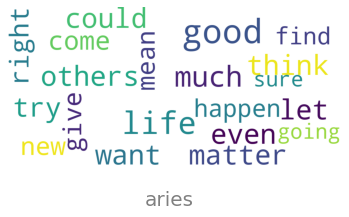

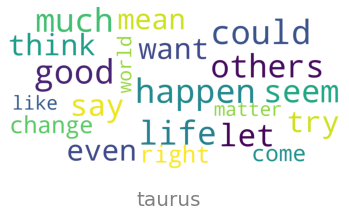

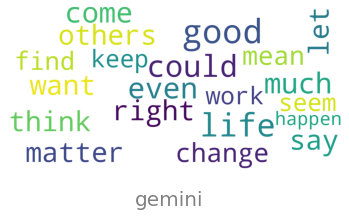

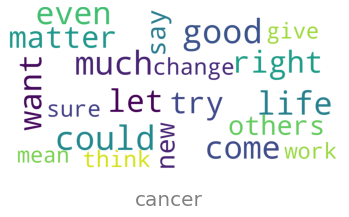

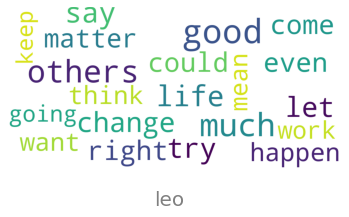

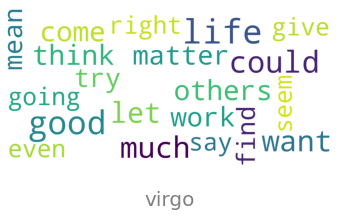

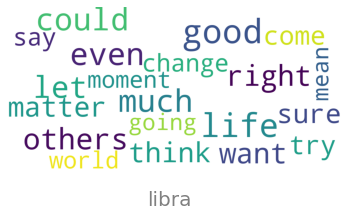

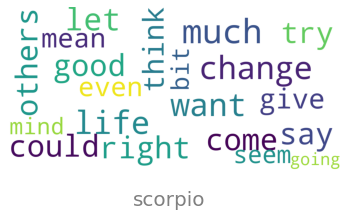

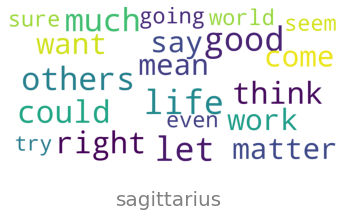

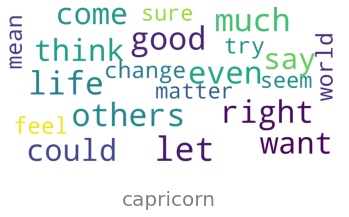

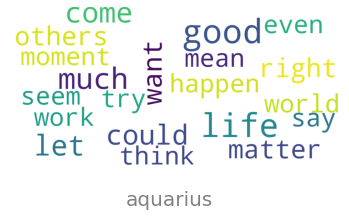

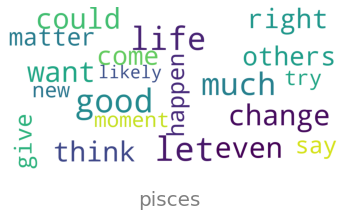

In [ ]:
for i in range (len(signs)):
    sign_curr = signs[i]
    sign_df = df_cloud1.loc[df_cloud1['sign']==sign_curr,]
    sign_horoscope = sign_df["horoscope"]
    sign_txt = sign_horoscope.iloc[0]
    show_wordcloud(sign_txt, sign_curr)  

This direct method does not yield satisfying results: most frequent words among the horoscope of each sign are similar and do not give explicit clue about sign's specificities.

**Method 2: TF-IDF analysis**

*TF-IDF computation*

In [ ]:
number_of_dimensions = 64 # complexity of the embedding

tfidf_vectorizer = TfidfVectorizer(
    analyzer='word',
    ngram_range=(1, 1),
    max_features=number_of_dimensions,
    max_df=1.0,
    min_df=10)
X_tfidf = tfidf_vectorizer.fit_transform(df_cloud2["horoscope"]).toarray()

*Display one random example of embedding*



In [ ]:
randrow = np.random.randint(11)

print(" == Text\n")
print(df_cloud2["horoscope"][randrow])
print("\n == Rating\n")
print(df_cloud2["sign"][randrow])
print("\n == Embedding\n")
print(X_tfidf[randrow])

 == Text

think seriously starting something new week something different used tuesday new moon inspire make kind courageous choices people prefer avoid people ask something today likely get good planets warn might smart stick already try make best necessarily better new moon takes place birth sign essential choose one aim stick one successful times year scatter energies dozen directions tough decision called must make live consequences planets warn worst possible thing right hedge bets come one side fence already making big plans make huge plans cosmic activity birth sign indicates things start accomplish fun may best certain areas one particular field endeavor equals focusing try things men enough point worrying things control applies areas life particularly friendships social activities buy ticket enjoy ride make effort avoid thoughts feelings doom gloom sun sign links ruler jupiter week effect could exaggerate wrong world still wonderful place people deal today drag feet find excus

*Computation of the TF-IDF vector*

In [ ]:
tfidf_vector=tfidf_vectorizer.fit_transform(df_cloud2['horoscope'])
print(tfidf_vector[:,10])

  (0, 0)	0.04221206352012961
  (1, 0)	0.05112872706186972
  (2, 0)	0.048107699066143435
  (3, 0)	0.06925776427325754
  (4, 0)	0.05845915479101642
  (5, 0)	0.0583752905629328
  (6, 0)	0.059966232608955616
  (7, 0)	0.0742531352248747
  (8, 0)	0.06535694060261076
  (9, 0)	0.06531114109923274
  (10, 0)	0.061678833835858364
  (11, 0)	0.051624684772116215


*Wordclouds generation*

We display the TF-IDF wordcloud associated to each child by applying the *show-wordcloud()* function to the list of the 20 words with higher TF-IDF scores.

Rk: The associated sign is display below the wordcloud. 

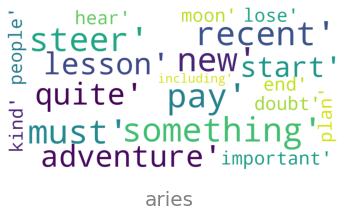

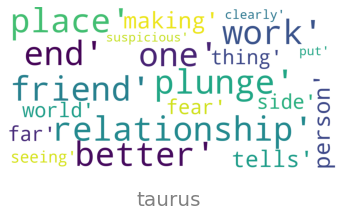

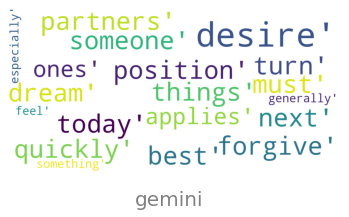

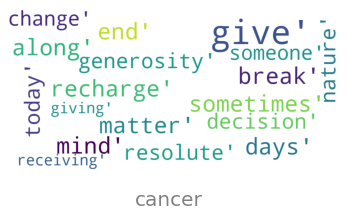

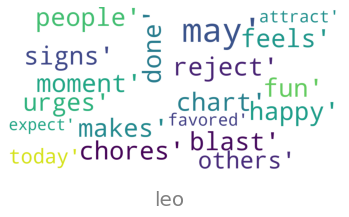

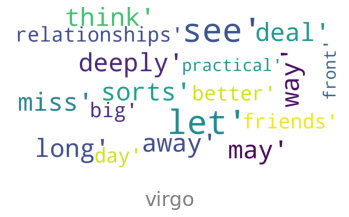

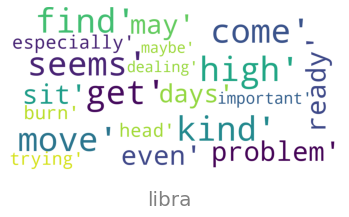

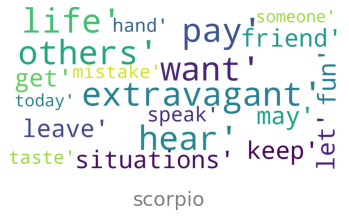

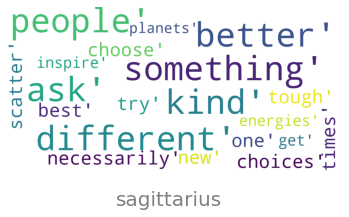

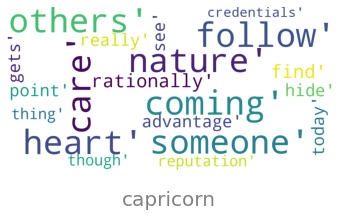

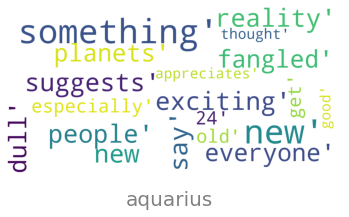

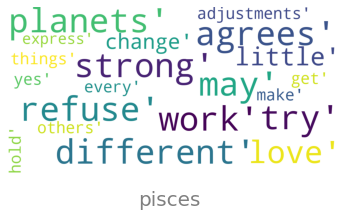

In [ ]:
for i in range (len(signs)):
    sign_curr = signs[i]
    sign_df = df_cloud2.loc[df_cloud2['sign']==sign_curr,]
    sign_horoscope = sign_df["horoscope"]
    sign_txt = sign_horoscope.iloc[0]

    row = tfidf_vector.getrow(i).toarray()[0].ravel() 
    
    top_twenty_index = row.argsort()[-20:]

    sign_txt = sign_txt.split()
    
    to_print = itemgetter(*top_twenty_index)(sign_txt)
    show_wordcloud(to_print, sign_curr)  


This method produces interesting results since each signs is associated with a different set of words that we expect to be related to the personality of this sign.

Here is some TF-IDF comparison with sign personnality traits according to the websites: 
http://nuclear.ucdavis.edu/~rpicha/personal/astrology/

https://blog.prepscholar.com/cancer-traits-personality 

https://blog.prepscholar.com/taurus-traits-personality 

We choose arbitrarly our two zodiac signs for comparison: **cancer** and **taurus**


*   **Cancer**



In [ ]:
sign = 'cancer'
ind = signs.index(sign)
print("The sign selected is:", sign)

#Get the 20 words with higher TF-IDF scores
sign_df = df_cloud2.loc[df_cloud2['sign']==sign,]
sign_horoscope = sign_df["horoscope"]
sign_txt = sign_horoscope.iloc[0]
row = tfidf_vector.getrow(ind).toarray()[0].ravel() 

#Get index of word with 20 highest TF-IDF scores   
top_twenty_index = row.argsort()[-20:]

#Print corresponding words
sign_txt = sign_txt.split()
to_print_cancer = itemgetter(*top_twenty_index)(sign_txt)
print(to_print_cancer)

The sign selected is: cancer
('matter', 'break', 'days', 'mind', 'sometimes', 'give', 'end', 'along', 'recharge', 'give', 'generosity', 'resolute', 'decision', 'nature', 'today', 'change', 'give', 'someone', 'receiving', 'giving')


Expected characteristics of the cancer: 

    - Emotional & loving & loyal & caring & generous
    - Intuitive & imaginative
    - Shrewd & cautious
    - Protective & sympathetic
    - Changeable & moody & enigmatic
    - Overemotional & touchy
    - Clinging & unable to let go & vindictive

*Does it seems accurate ?* Quite well

In [ ]:
print("Emotional / Loving / Protective / Caring / Generous:", to_print_cancer[10], to_print_cancer[19], to_print_cancer[18], to_print_cancer[17])
print("Shrewd / cautious :", to_print_cancer[0], to_print_cancer[3], to_print_cancer[11], to_print_cancer[12])
print("Intuitive / imaginative / (spirit-related traits) :", to_print_cancer[3], to_print_cancer[8], to_print_cancer[13])
print("Changeable / moody :", to_print_cancer[1], to_print_cancer[15])
print("Clinging / Unable to let go :", to_print_cancer[11], to_print_cancer[12])

Emotional / Loving / Protective / Caring / Generous: generosity giving receiving someone
Shrewd / cautious : matter mind resolute decision
Intuitive / imaginative / (spirit-related traits) : mind recharge nature
Changeable / moody : break change
Clinging / Unable to let go : resolute decision



*   **Taurus**



In [ ]:
sign = 'taurus'
ind = signs.index(sign)
print("The sign selected is:", sign)

#Get the 20 words with higher TF-IDF scores
sign_df = df_cloud2.loc[df_cloud2['sign']==sign,]
sign_horoscope = sign_df["horoscope"]
sign_txt = sign_horoscope.iloc[0]
row = tfidf_vector.getrow(ind).toarray()[0].ravel() 

#Get index of word with 20 highest TF-IDF scores   
top_twenty_index = row.argsort()[-20:]

#Print corresponding words
sign_txt = sign_txt.split()
to_print_taurus = itemgetter(*top_twenty_index)(sign_txt)
print(to_print_taurus)

The sign selected is: taurus
('work', 'relationship', 'one', 'friend', 'place', 'plunge', 'better', 'end', 'making', 'person', 'tells', 'thing', 'fear', 'world', 'side', 'far', 'seeing', 'suspicious', 'put', 'clearly')


Expected characteristics of the taurus:

    - Patient & reliable & value honesty above all else
    - Warmhearted & loving
    - Persistent & determined & hard-worker & ambitious
    - Security loving & placid & confort in stability and consistency
    - Can take their pleasure-seeking ways too far
    - Resentful & inflexible & perfectionists
    - Greedy & enjoy things luxurious and cozy

Does it seem accurate ? Quite well

In [ ]:
print("Persistent / Determined / Hard-worker / Ambitious :", to_print_taurus[0],to_print_taurus[8],to_print_taurus[5],to_print_taurus[6],to_print_taurus[15])
print("Placid / Security loving / Stability :", to_print_taurus[12],to_print_taurus[17])
print("Perfectionist / Inflexible / Pleasure-seeking to far :", to_print_taurus[5],to_print_taurus[6],to_print_taurus[15])
print("Reliable / Honest / Warmhearted / loving:", to_print_taurus[1], to_print_taurus[10], to_print_taurus[19],to_print_taurus[1],to_print_taurus[3],to_print_taurus[9])
print("Enjoy things luxury and cosy:", to_print_taurus[11])


Persistent / Determined / Hard-worker / Ambitious : work making plunge better far
Placid / Security loving / Stability : fear suspicious
Perfectionist / Inflexible / Pleasure-seeking to far : plunge better far
Reliable / Honest / Warmhearted / loving: relationship tells clearly relationship friend person
Enjoy things luxury and cosy: thing


**Conclusion Step 3**

The horoscope predictions from our dataset seems to be at least partially sign-specifics since the TF-IDF methods (which also takes into account that a word is rare among the other text of the corpus) highlights different words for each sign. Moreover these words seems to be linked to the personality traits of each sign. 

Hence it makes sense to building a text generator algorithm able to take into account the sign to produce the horoscope. 

## **PART 2: Horoscope predictions generation**

### **Step 1 : Create train and test sets**

**Split the original dataset into a train and a test set, corresponding respectively to 90% and 10% of the data**

In [ ]:
#Make a copy of the original dataframe
df_LSTM = df.copy(deep=True)
#Test set : 10% of the data
df_test = df_LSTM.groupby('sign').sample(frac=.1) 
#Train set : 90% of the data
df_temp = df_LSTM.drop_duplicates().merge(df_test.drop_duplicates(), on=df_test.columns.to_list(), 
                   how='left', indicator=True)
df_train = df_temp.loc[df_temp._merge=='left_only',df_temp.columns!='_merge']

**Train set composition**

In [ ]:
#Extract count and proportion for each sign
nb_train = df_train['sign'].value_counts()
prop_train = df_train['sign'].value_counts(normalize=True)
#Merge the two previous results
train_compo = pd.concat([nb_train, prop_train], axis=1)
#Rename the final columns 
train_compo.columns = ['nb','prop']

print(train_compo)

              nb      prop
leo          977  0.083740
scorpio      976  0.083655
gemini       975  0.083569
libra        974  0.083483
pisces       973  0.083398
taurus       972  0.083312
sagittarius  972  0.083312
capricorn    971  0.083226
virgo        971  0.083226
aquarius     970  0.083140
aries        969  0.083055
cancer       967  0.082883


**Test set composition**

In [ ]:
#Extract count and proportion for each sign
nb_test = df_test['sign'].value_counts()
prop_test = df_test['sign'].value_counts(normalize=True)
#Merge the two previous results
test_compo = pd.concat([nb_test, prop_test], axis=1)
#Rename the final columns 
test_compo.columns = ['nb','prop']

print(test_compo)

              nb      prop
libra        108  0.083398
pisces       108  0.083398
sagittarius  108  0.083398
taurus       108  0.083398
aries        108  0.083398
aquarius     108  0.083398
scorpio      108  0.083398
virgo        108  0.083398
gemini       108  0.083398
leo          108  0.083398
capricorn    108  0.083398
cancer       107  0.082625


**Cleaning the data:** Remove punctuation and convert to lowercase.
We also drop unseful columns "id" and "date".

In [ ]:
#Train set
df_train = text_cleaning3(df_train.copy(deep=True), 'horoscope')
df_train = df_train.reset_index(drop = True)
df_train = df_train.drop(["id", "date"], axis=1)

#Test set
df_test = text_cleaning3(df_test.copy(deep=True), 'horoscope')
df_test = df_test.reset_index(drop = True)
df_test = df_test.drop(["id", "date"], axis=1)

### **Step 2: Model specification and associated processing methods**

Our text generation model relies on several functions: 

*   Function *get_sequence_of_tokens* = Transformation of original sentences into N-Grams tokens

*   Function *generate_padded_sequences* = Transformation of N-Grams token into padded vectors (predictors and label, i.e. the next word of the initial sentence)

*   Function *prep_LSTM* = Select the subset of the initial horoscope predictions associated to the targetter sign (passed as an argument) and apply to the resulting list of sentences the two preprocessing functions mentionned above. 

*   Function *create_model* = Generation of the LSTM model. 

*   Function *generate_text* = Generate new sentences containing a requested number of words, from a initial text extract. 






**Transformation of the corpus sentences into N-gram tokens**

In [ ]:
tokenizer = Tokenizer()

def get_sequence_of_tokens(corpus):
    ## tokenization
    tokenizer.fit_on_texts(corpus)
    total_words = len(tokenizer.word_index) + 1
    
    ## convert data to sequence of tokens 
    input_sequences = []
    for line in corpus:
        token_list = tokenizer.texts_to_sequences([line])[0]
        for i in range(1, len(token_list)):
            n_gram_sequence = token_list[:i+1]
            input_sequences.append(n_gram_sequence)
    return input_sequences, total_words

**Sequences padding**

The set of tokens sequences might include sequences of different lengths. Before starting training the model, we need to pad the sequences and make their lengths equal. 

In [ ]:
def generate_padded_sequences(input_sequences, total_words):
    max_sequence_len = max([len(x) for x in input_sequences])
    input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
    
    predictors, label = input_sequences[:,:-1],input_sequences[:,-1]
    label = ku.to_categorical(label, num_classes=total_words)
    return predictors, label, max_sequence_len

The above function creted an input vector, which contains same length N-grams sequence build from the corpus, and a label vector, which is the next word of the N-gram, which can be used for the training purposes.

**Function to apply the preprocessing steps for the corpus of horoscope associated to a choosen sign**

This function creates the N-grams sequences and apply the padding process to the subset of horoscope predictions associated to the targetted sign.

In [ ]:
def prep_LSTM(df_set, target_sign):
  
  current_sign = target_sign
  
  df_sign = df_set[df_set["sign"] == current_sign]
  df_sign = df_sign.drop(["sign"], axis=1)
  sign_corpus = list(df_sign['horoscope'])

  sign_seq, n_words = get_sequence_of_tokens(sign_corpus)
  sign_preds, sign_label, max_seq_len = generate_padded_sequences(sign_seq,n_words)

  return n_words, sign_preds, sign_label, max_seq_len

**Function to generate the LSTM model**

The model is created according to: 
* the maximum length of padded vectors generated from the training set,
* the total number of words in the vocabulary used in the training corpus. 

The model used is a Long short-term memory (LSTM) model, i.e. is build as an artificial recurrent neural network (RNN) architecture.
It includes: 


*   An *embedding* input layer 
*   Two LSTM *hidden layers* with *dropout rate* of 10%
*   One *hidden layer* with *relu activation function*
*   An *output layer* with a *softmax activation function*

The optimizer used is *ADAM* and the loss minimized is the *categorical cross-entropy*. 

In [ ]:
def create_model(max_sequence_len, total_words):
    input_len = max_sequence_len - 1
    model = Sequential()
    
    # Add Input Embedding Layer
    model.add(Embedding(total_words, 10, input_length=input_len))
    
    # Add Hidden Layer 1 - LSTM Layer
    model.add(LSTM(100, return_sequences=True))
    model.add(Dropout(0.1))
    
    # Add Hidden Layer 2 - LSTM Layer
    model.add(LSTM(100))
    model.add(Dropout(0.1))
    
    # Add Hidden Layer 3 - Relu
    model.add(Dense(100, activation='relu'))

    # Add Output Layer
    model.add(Dense(total_words, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
    
    return model

**Text generator function**

This function takes an initial horoscope prediction (from the initial dataset, in generak from a test set independent from the training set).
It returns the initial horoscope predictions extended by a certain number (controlled by the argument *next_words*) of new predicted words which form the artificially generated horoscope. 

In [ ]:
def generate_text(seed_text, next_words, model, max_sequence_len):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        predicted = model.predict_classes(token_list, verbose=0)
        
        output_word = ""
        for word,index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += " "+output_word
    return seed_text.title()

### **Step 3: Test of the text generation model**

This step consists in implemented the above model for an arbitrarly choosen sign to check the execution and evaluate the results of the generative functions introduced previously. 

If the model is consider satisfying, the last step would be to implement a global horoscope generator function. 

*(Arbirtrarly) target sign choice*

In [ ]:
s_ind = np.random.randint(0, len(signs))
current_sign = signs[s_ind]
print("Horoscope generation example for sign:", current_sign)

Horoscope generation example for sign: gemini


*Preprocessing of the training set*

In [ ]:
n_words_train, preds_train, label_train, max_seq_len_train = prep_LSTM(df_train, current_sign)

*Model creation*

In [ ]:
model = create_model(max_seq_len_train, n_words_train)
model.summary() #Display model structure

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 52, 10)            37590     
_________________________________________________________________
lstm_2 (LSTM)                (None, 52, 100)           44400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 52, 100)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 3759)             

*Model fitting*

In [ ]:
model.fit(preds_train, label_train, batch_size=128, epochs=100, verbose=1, validation_split=0.1)

Train on 38710 samples, validate on 4302 samples
Epoch 1/100
38710/38710 [==============================] - 111s 3ms/sample - loss: 6.0660 - accuracy: 0.0626 - val_loss: 5.8872 - val_accuracy: 0.0616
Epoch 2/100
38710/38710 [==============================] - 102s 3ms/sample - loss: 5.6885 - accuracy: 0.0642 - val_loss: 5.7494 - val_accuracy: 0.0681
Epoch 3/100
38710/38710 [==============================] - 105s 3ms/sample - loss: 5.4852 - accuracy: 0.0768 - val_loss: 5.6083 - val_accuracy: 0.0788
Epoch 4/100
38710/38710 [==============================] - 104s 3ms/sample - loss: 5.2913 - accuracy: 0.0924 - val_loss: 5.5252 - val_accuracy: 0.0886
Epoch 5/100
38710/38710 [==============================] - 101s 3ms/sample - loss: 5.1639 - accuracy: 0.0979 - val_loss: 5.5063 - val_accuracy: 0.0948
Epoch 6/100
38710/38710 [==============================] - 104s 3ms/sample - loss: 5.0708 - accuracy: 0.1050 - val_loss: 5.4471 - val_accuracy: 0.1030
Epoch 7/100
38710/38710 [====================

*Horoscope generation*

In [ ]:
#Test corpus extraction
df_target = df_test[df_test["sign"] == current_sign]
df_target = df_target.drop(["sign"], axis=1)
target_corpus = list(df_target['horoscope'])

In [ ]:
#Choose a random initial horoscope from the text corpus
ind = np.random.randint(0, len(target_corpus))

init_text = target_corpus[ind]
print("Initial horoscope:",init_text)

Initial horoscope: attitude is everything  if you think that a task will be boring then most likely it will be  however  if you approach the same task with confidence and a sense of adventure you will find ways to make it fun  life is what you choose to make it 


In [ ]:
#Initial horoscope completed by a new sentence composed of 100 generated words. 
new_horoscope = generate_text(init_text,  100, model, max_seq_len_train)
print("Completed sentence: ", new_horoscope)

Completed sentence:  Attitude Is Everything  If You Think That A Task Will Be Boring Then Most Likely It Will Be  However  If You Approach The Same Task With Confidence And A Sense Of Adventure You Will Find Ways To Make It Fun  Life Is What You Choose To Make It  Happen But You Will Be A Few Regrets But You Will Be A Few Tears Before Bedtime The First Only Your Overactive Imagination Stake You Have Been The Chance To Make It Happen But Don T Worry About You Can Do You Down Again And Because You Are Not Entitled To Be A Bit On The Most Of The Coming Week And That S Okay You Will Be Looking To Your Generosity Is Not A Case To Refuse It You Can Do It You Are Not A Livewire High You Will Be A Resounding Success If You Want To Be


**Results analysis**

We focus on the first word predicted to complete the initial sentence.

In [ ]:
print("Sentence to be completed: ", init_text)
print("Last words of the sentence to be completed (last N-Grams): ", init_text[-36:-1])

Sentence to be completed:  attitude is everything  if you think that a task will be boring then most likely it will be  however  if you approach the same task with confidence and a sense of adventure you will find ways to make it fun  life is what you choose to make it 
Last words of the sentence to be completed (last N-Grams):   life is what you choose to make it


In [ ]:
token_list = tokenizer.texts_to_sequences([init_text])[0]
token_list = pad_sequences([token_list], maxlen=max_seq_len_train-1, padding='pre')
predicted = model.predict_classes(token_list, verbose=0)

for word,index in tokenizer.word_index.items():
  if index == predicted:
    output_word = word
    break
first_word = output_word

print("First word generate to completed the above sentence: ", first_word.title())

First word generate to completed the above sentence:  Happen


The first word predicted seems to make sense, especially if we focus on the meaning of the last word "you choose to make it happen".


We want to look at which other words the algorithm predicted as likely in this context. 

* The table below lists, by decreasing probability order, the **20 most likely words predicted by the model** to be the first word to complete the initial horoscope sentence. 

In [ ]:
token_list = tokenizer.texts_to_sequences([init_text])[0]
token_list = pad_sequences([token_list], maxlen=max_seq_len_train-1, padding='pre')
predict_proba = model.predict(token_list, verbose=0)
pred_classes = predict_proba[0].argsort()[-20:][::-1]
pred_scores = itemgetter(*pred_classes)(predict_proba[0])

df_prediction = pd.DataFrame({'index': pred_classes, 'score': pred_scores})
print(df_prediction)

    index     score
0     177  0.147425
1     162  0.055708
2      96  0.051634
3     136  0.042936
4     258  0.040506
5     350  0.036525
6     123  0.029118
7      13  0.025887
8      35  0.021876
9       9  0.019758
10      1  0.018269
11     10  0.017068
12     68  0.016543
13     15  0.015734
14     19  0.015540
15     12  0.015393
16   3287  0.014497
17    238  0.013805
18      4  0.011491
19    187  0.010723


* The table below display the words associated to each probability. 



In [ ]:
words_top20 = []

for ind in df_prediction['index']: 
  for word,index in tokenizer.word_index.items(): 
    if index == ind:
      words_top20.append(word)

In [ ]:
df_prediction = pd.DataFrame({'index': pred_classes, 'score': pred_scores, 'word': words_top20})
print(df_prediction)

    index     score       word
0     177  0.147425     happen
1     162  0.055708       easy
2      96  0.051634      right
3     136  0.042936       done
4     258  0.040506        pay
5     350  0.036525      tough
6     123  0.029118      wrong
7      13  0.025887         in
8      35  0.021876         as
9       9  0.019758          a
10      1  0.018269        you
11     10  0.017068       will
12     68  0.016543       even
13     15  0.015734        but
14     19  0.015540        for
15     12  0.015393       that
16   3287  0.014497  instantly
17    238  0.013805  difficult
18      4  0.011491        and
19    187  0.010723     coming


The word which is selected by the algorithm, "happen", has a probability of 0.15, which is large in comparison of the next more likely word (with probability 0.055) and which is also large according to the total size of the vocabulary: 

In [ ]:
print("For this sign, the vocabulary contains :", n_words_train, "words.")

For this sign, the vocabulary contains : 3759 words.


**Graphical representation of the most propable first word propose by the model**

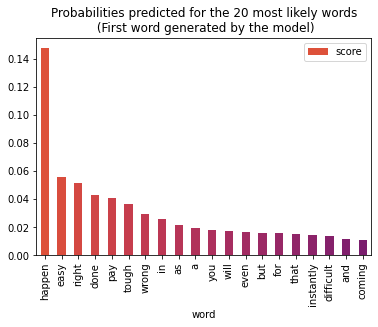

In [ ]:
my_colors = plt.cm.inferno_r(np.linspace(.4, .8, 30))
df_prediction.plot.bar(x='word',y='score', color= my_colors, title="Probabilities predicted for the 20 most likely words\n (First word generated by the model)")

The above graph illustrates the high probability obtained by the word "happen", selected by the model, in comparison of the probabilities obtained by the other words detected as likely by the model to be firts new word added to the initial sentence. 

Moreover, these probabilities and this ranking seems meaningfull, since there is several verbs (logical after the pronoun "it"). Some other words makes sense with the expression "make it" such that "make it *easy*" or "make it *right*". Finally, some other word have high probabilities because they are frequently used in the initial horoscope sentences used to train the model, such that "you" for example. 

### **Step 4: Global horoscope prediction function**

**Global function 1**

In [ ]:
def horoscope_prediction(target_sign, n_words_generated):
  
  #---Preprocessing of the training set---#
  # - subset training corpus associated to the target sign
  # - N-Grams generation
  # - Padded vectors generation
  n_words_train, preds_train, label_train, max_seq_len_train = prep_LSTM(df_train, target_sign)

  #---LSTM model generation---#
  model = create_model(max_seq_len_train, n_words_train)
 
  #---Model training---#
  model.fit(preds_train, label_train, batch_size=128, epochs=100, verbose=1, validation_split=0.1)
  
  #---Extraction of test horoscopes corpus from test set---#
  df_target = df_test[df_test["sign"] == sign]
  df_target = df_target.drop(["sign"], axis=1)
  target_corpus = list(df_target['horoscope'])

  #---Initial horosocope prediction to be completed---#
  #Random choice
  ind = np.random.randint(0, len(target_corpus))
  init_text = target_corpus[ind]
  print("Initial horoscope to be completed:", init_text)

  #---Final horoscope generation---#
  predicted_horoscope = generate_text(init_text,  n_words_generated, model, max_seq_len_train)

  return predicted_horoscope

**Example of horoscope generation**

In [ ]:
print(horoscope_prediction('cancer', 100))

Train on 38618 samples, validate on 4291 samples
Epoch 1/100
38618/38618 [==============================] - 99s 3ms/sample - loss: 6.0457 - accuracy: 0.0601 - val_loss: 5.8875 - val_accuracy: 0.0620
Epoch 2/100
38618/38618 [==============================] - 95s 2ms/sample - loss: 5.7162 - accuracy: 0.0632 - val_loss: 5.6889 - val_accuracy: 0.0674
Epoch 3/100
38618/38618 [==============================] - 95s 2ms/sample - loss: 5.5117 - accuracy: 0.0758 - val_loss: 5.5713 - val_accuracy: 0.0825
Epoch 4/100
38618/38618 [==============================] - 96s 2ms/sample - loss: 5.3549 - accuracy: 0.0874 - val_loss: 5.5037 - val_accuracy: 0.0890
Epoch 5/100
38618/38618 [==============================] - 95s 2ms/sample - loss: 5.2505 - accuracy: 0.0971 - val_loss: 5.4598 - val_accuracy: 0.1046
Epoch 6/100
38618/38618 [==============================] - 99s 3ms/sample - loss: 5.1584 - accuracy: 0.1054 - val_loss: 5.4038 - val_accuracy: 0.1070
Epoch 7/100
38618/38618 [==========================

**Global function(s) 2: One can also prefer using 2 separate functions: one to build and train the model and one to predict.**

This also to re-use a trained if we want to make several predictions for the same size. 

It is particularly usefull since the computational time required for the model to be trained is quite long.

*Function to build and train the model*

In [ ]:
def horoscope_prediction_model(target_sign):
  
  #---Preprocessing of the training set---#
  # - subset training corpus associated to the target sign
  # - N-Grams generation
  # - Padded vectors generation
  n_words_train, preds_train, label_train, max_seq_len_train = prep_LSTM(df_train, target_sign)

  #---LSTM model generation---#
  model = create_model(max_seq_len_train, n_words_train)
 
  #---Model training---#
  model.fit(preds_train, label_train, batch_size=128, epochs=100, verbose=1, validation_split=0.1)
  
  return max_len_seq_train, model

*Fonction to generate and display the prediction*

In [ ]:
def horoscope_prediction_predict(target_sign, trained_model, n_words_generated, len_seq):

  #---Extraction of test horoscopes corpus from test set---#
  df_target = df_test[df_test["sign"] == target_sign]
  df_target = df_target.drop(["sign"], axis=1)
  target_corpus = list(df_target['horoscope'])

  #---Initial horosocope prediction to be completed---#
  #Random choice
  ind = np.random.randint(0, len(target_corpus))
  init_text = target_corpus[ind]
  print("Initial horoscope to be completed:", init_text)

  #---Final horoscope generation---#
  predicted_horoscope = generate_text(init_text,  n_words_generated, trained_model, len_seq)

  return predicted_horoscope

**Example of horoscope generation**

In [ ]:
len_train, model_aries = horoscope_prediction_model('aries')
print(horoscope_prediction_predict('aries', model_aries, 100, len_train))

## **CONCLUSION**

The horoscope generator model that we have implemented yields interesting results as it is able to select a sequence of words to complete a real horoscope prediction. The context of the previous sentence seems to be partially understanded by the model since the new sentence generated included meaningfull structures according to this context. 

The main drawback of the method arise when we try to generate long sentences since several word repetitions appears at the end of the generated sentences including more than 50 to 100 words. 

Finally the execution time required to train the model is important, which also constitues a drawback, especially to produce sign-specific predictions which requires to train independently the model for each sign. 

In a nutshell, it would be interesting to investigate other model spedificaton, such that bidimensional LSTM, to see whether it could improve our results. 